In [4]:
"""
Decision Tree Regression — Beginner to Advanced (Regression only)


What this script covers (industry-style):
1) Synthetic + optional CSV dataset loading
2) Train/validation/test split & metrics (MAE, RMSE, R^2, MAPE)
3) Baseline models: mean predictor, linear baseline (for comparison)
4) DecisionTreeRegressor basics (fit/predict, different criteria)
5) Full preprocessing Pipeline (imputation, one-hot for categoricals, scaling optional)
6) Hyperparameter tuning with GridSearchCV (max_depth, min_samples_leaf, max_features, ccp_alpha, etc.)
7) Cost-complexity pruning path exploration & selection via CV
8) Feature importances (impurity) + Permutation importance
9) Partial Dependence plots (1D and 2D)
10) Learning curve & validation curve utilities
11) Handling target distributions: squared_error, absolute_error (median), poisson
12) Sample weights example
13) Model persistence with joblib
14) Visualization: predictions vs actual, residual plots, tree visualization


Notes:
- Only regression tasks are demonstrated (no classification).
- Requires: scikit-learn >= 1.2, matplotlib, numpy, pandas, joblib.
"""


import warnings
warnings.filterwarnings("ignore")


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, GridSearchCV, KFold, ShuffleSplit, learning_curve, validation_curve
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
import joblib


RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [5]:
# -----------------------------
# 1) Data — synthetic + optional CSV
# -----------------------------
# Synthetic non-linear regression with interactions
N = 1200
X1 = np.random.uniform(-3, 3, size=N)
X2 = np.random.uniform(0, 10, size=N)
X3 = np.random.normal(5, 2, size=N)
# non-linear target with piecewise behavior and noise
y_true = (
2*np.sin(X1) + 0.3*(X2**1.5) - 1.5*np.where(X3>5, (X3-5), 0) + 10
)
noise = np.random.normal(0, 2.0, size=N)
y = y_true + noise


df = pd.DataFrame({"x1": X1, "x2": X2, "x3": X3, "y": y})


# OPTIONAL: Uncomment to use your CSV (must set target_col and feature cols)
# df = pd.read_csv("your_regression_dataset.csv")
# target_col = "target"
# feature_cols = [c for c in df.columns if c != target_col]
# X_df = df[feature_cols]
# y = df[target_col].values


X_df = df.drop(columns=["y"]) # features


# Create a small categorical feature to demonstrate one-hot
X_df["cat"] = pd.qcut(X_df["x2"], q=4, labels=["Q1","Q2","Q3","Q4"]).astype("category")


# introduce some missing values
mask = np.random.rand(len(X_df)) < 0.05
X_df.loc[mask, "x3"] = np.nan


# Train/valid/test split
X_train_val, X_test, y_train_val, y_test = train_test_split(
X_df, y, test_size=0.2, random_state=RANDOM_STATE
)
X_train, X_valid, y_train, y_valid = train_test_split(
X_train_val, y_train_val, test_size=0.2, random_state=RANDOM_STATE
)

In [6]:
# -----------------------------
# 2) Metrics helpers
# -----------------------------

def regression_report(y_true, y_pred, label="model"):
  mae = mean_absolute_error(y_true, y_pred)
  rmse = mean_squared_error(y_true, y_pred, squared=False)
  r2 = r2_score(y_true, y_pred)
  mape = mean_absolute_percentage_error(y_true, y_pred)
  print(f"[{label}] MAE={mae:.4f} RMSE={rmse:.4f} R2={r2:.4f} MAPE={mape:.3f}")

In [7]:
# -----------------------------
# 3) Baselines
# -----------------------------
mean_baseline = DummyRegressor(strategy="mean").fit(X_train, y_train)
lin_baseline = Pipeline([
("pre", ColumnTransformer([
("num", Pipeline([
("imp", SimpleImputer(strategy="median")),
("sc", StandardScaler())
]), ["x1","x2","x3"]),
("cat", Pipeline([
("imp", SimpleImputer(strategy="most_frequent")),
("oh", OneHotEncoder(handle_unknown="ignore"))
]), ["cat"])
])),
("lin", LinearRegression())
]).fit(X_train, y_train)


print("\n=== Baselines ===")
regression_report(y_valid, mean_baseline.predict(X_valid), label="Dummy(mean)")
regression_report(y_valid, lin_baseline.predict(X_valid), label="LinearRegression")


=== Baselines ===
[Dummy(mean)] MAE=3.4061 RMSE=4.1740 R2=-0.0077 MAPE=0.372
[LinearRegression] MAE=1.9484 RMSE=2.4027 R2=0.6661 MAPE=0.198


In [9]:
# -----------------------------
# 4) DecisionTreeRegressor — basic fit with squared_error (MSE) criterion
# -----------------------------
num_features = ["x1","x2","x3"]
cat_features = ["cat"]


preprocess = ColumnTransformer([
   ("num", Pipeline([
   ("imp", SimpleImputer(strategy="median"))
   ]), num_features),
   ("cat", Pipeline([
   ("imp", SimpleImputer(strategy="most_frequent")),
   ("oh", OneHotEncoder(handle_unknown="ignore"))
   ]), cat_features)
])


basic_tree = Pipeline([
   ("pre", preprocess),
   ("tree", DecisionTreeRegressor(
     criterion="squared_error",
     random_state=RANDOM_STATE
   ))
])


basic_tree.fit(X_train, y_train)
print("\n=== Basic Decision Tree (squared_error) ===")
regression_report(y_valid, basic_tree.predict(X_valid), label="Basic Tree")


# Try alternative criteria: absolute_error (median) and poisson (for counts)
median_tree = Pipeline([
   ("pre", preprocess),
   ("tree", DecisionTreeRegressor(
      criterion="absolute_error", # LAD, robust to outliers; predicts median per leaf
      random_state=RANDOM_STATE
   ))   
]).fit(X_train, y_train)
regression_report(y_valid, median_tree.predict(X_valid), label="Tree absolute_error (median)")


poisson_tree = Pipeline([
   ("pre", preprocess),
   ("tree", DecisionTreeRegressor(
      criterion="poisson", # better for count-like targets (y >= 0)
      random_state=RANDOM_STATE
   ))
])
# Only use poisson if y is non-negative; our synthetic y might be >0; enforce shift if needed
if np.all(y_train >= 0):
   poisson_tree.fit(X_train, y_train)
   regression_report(y_valid, poisson_tree.predict(X_valid), label="Tree poisson")
else:
   print("[Info] Skipping poisson criterion: y has negative values in training set.")


=== Basic Decision Tree (squared_error) ===
[Basic Tree] MAE=2.2266 RMSE=2.7988 R2=0.5469 MAPE=0.216
[Tree absolute_error (median)] MAE=2.6356 RMSE=3.2210 R2=0.3999 MAPE=0.252
[Info] Skipping poisson criterion: y has negative values in training set.


In [10]:
# -----------------------------
# 5) Hyperparameter tuning with GridSearchCV (common in industry)
# -----------------------------
param_grid = {
"tree__max_depth": [3, 5, 8, None],
"tree__min_samples_split": [2, 5, 10, 20],
"tree__min_samples_leaf": [1, 2, 5, 10],
"tree__max_features": [None, "auto", "sqrt", 0.6],
"tree__ccp_alpha": [0.0, 0.001, 0.01]
}
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)


gs = GridSearchCV(
estimator=Pipeline([("pre", preprocess), ("tree", DecisionTreeRegressor(random_state=RANDOM_STATE))]),
param_grid=param_grid,
scoring="neg_root_mean_squared_error",
cv=cv,
n_jobs=-1,
verbose=0
)


gs.fit(X_train, y_train)
print("\n=== GridSearch Best Params ===\n", gs.best_params_)
print("Best CV RMSE:", -gs.best_score_)


best_tree = gs.best_estimator_
regression_report(y_valid, best_tree.predict(X_valid), label="Best Tree (grid)")


=== GridSearch Best Params ===
 {'tree__ccp_alpha': 0.0, 'tree__max_depth': 5, 'tree__max_features': None, 'tree__min_samples_leaf': 1, 'tree__min_samples_split': 10}
Best CV RMSE: 2.458235063773737
[Best Tree (grid)] MAE=1.9749 RMSE=2.4632 R2=0.6491 MAPE=0.203



Pruning: best ccp_alpha by holdout = 0.036588, RMSE=2.4399


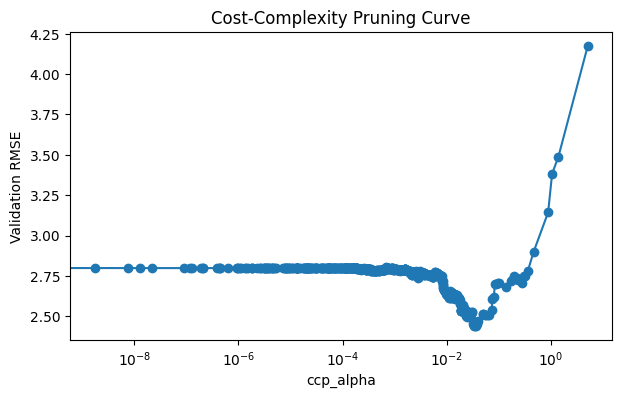

[Pruned Tree (ccp_alpha)] MAE=1.9834 RMSE=2.4399 R2=0.6557 MAPE=0.203


In [11]:
# -----------------------------
# 6) Cost-Complexity Pruning path & CV selection of ccp_alpha
# -----------------------------
# Fit unpruned tree to extract path. We must use the transformed training data for path; easiest: fit a tree on preprocessed arrays.
X_pre = preprocess.fit_transform(X_train, y_train)
raw_tree = DecisionTreeRegressor(random_state=RANDOM_STATE)
raw_tree.fit(X_pre, y_train)
path = raw_tree.cost_complexity_pruning_path(X_pre, y_train)
alphas, impurities = path.ccp_alphas, path.impurities


rmse_per_alpha = []
for a in alphas:
   tree = DecisionTreeRegressor(random_state=RANDOM_STATE, ccp_alpha=a)
   tree.fit(X_pre, y_train)
   # evaluate on validation (transform X_valid with fitted preprocess)
   Xv = preprocess.transform(X_valid)
   y_pred = tree.predict(Xv)
   rmse = mean_squared_error(y_valid, y_pred, squared=False)
   rmse_per_alpha.append(rmse)


best_alpha = alphas[int(np.argmin(rmse_per_alpha))]
print(f"\nPruning: best ccp_alpha by holdout = {best_alpha:.6f}, RMSE={min(rmse_per_alpha):.4f}")


plt.figure(figsize=(7,4))
plt.plot(alphas, rmse_per_alpha, marker='o')
plt.xlabel("ccp_alpha")
plt.ylabel("Validation RMSE")
plt.title("Cost-Complexity Pruning Curve")
plt.xscale("log")
plt.show()


# Build final pruned pipeline with that alpha
pruned_tree = Pipeline([
("pre", preprocess),
("tree", DecisionTreeRegressor(random_state=RANDOM_STATE, ccp_alpha=best_alpha))
]).fit(X_train, y_train)
regression_report(y_valid, pruned_tree.predict(X_valid), label="Pruned Tree (ccp_alpha)")


Top impurity importances:
 x2        0.56101
x3        0.27579
x1        0.16320
cat_Q1    0.00000
cat_Q2    0.00000
cat_Q3    0.00000
cat_Q4    0.00000
dtype: float64


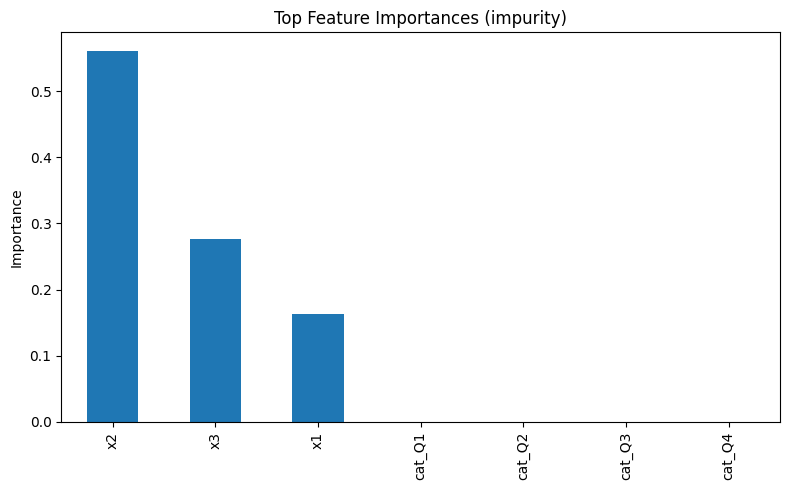


Top permutation importances:
 x2        0.811621
x3        0.267510
x1        0.217979
cat_Q1    0.000000
dtype: float64


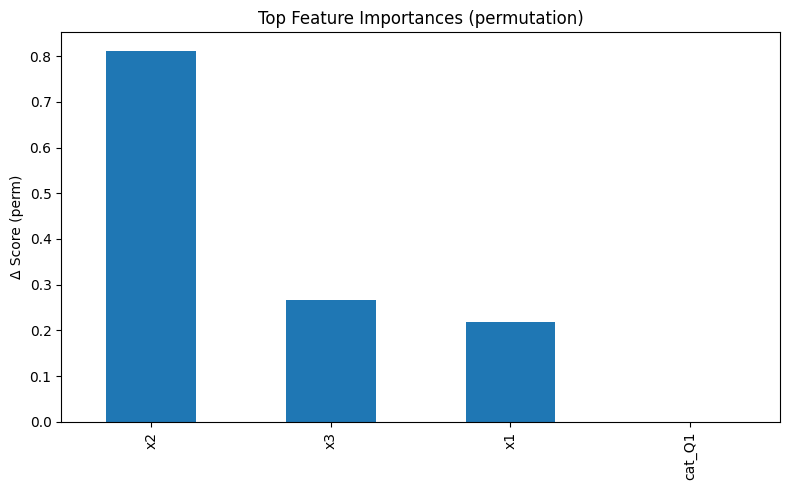

In [13]:
# -----------------------------
# 7) Feature importances & permutation importance (Fixed)
# -----------------------------
# Refit the best tree to ensure it's trained
best_tree.fit(X_train, y_train)

# Access the inner DecisionTreeRegressor
inner = best_tree.named_steps["tree"]

# Get feature names from preprocessing
preprocessor = best_tree.named_steps["pre"]

# Numeric features remain the same
num_features_out = num_features  

# Get categorical feature names from OneHotEncoder
oh = preprocessor.named_transformers_["cat"].named_steps["oh"]
cat_features_out = list(oh.get_feature_names_out(cat_features))

# Final feature names
feature_names = num_features_out + cat_features_out

# ----------------- Impurity-based importance -----------------
imp = pd.Series(inner.feature_importances_, index=feature_names)
imp = imp.sort_values(ascending=False)

print("\nTop impurity importances:\n", imp.head(10))

plt.figure(figsize=(8, 5))
imp.head(20).plot(kind='bar')
plt.ylabel("Importance")
plt.title("Top Feature Importances (impurity)")
plt.tight_layout()
plt.show()

# ----------------- Permutation importance -----------------
perm = permutation_importance(
    best_tree, X_valid, y_valid,
    n_repeats=10, random_state=RANDOM_STATE, n_jobs=-1
)

# Match lengths: use only the number of features actually in model
perm_imp = pd.Series(perm.importances_mean, index=feature_names[:len(perm.importances_mean)])
perm_imp = perm_imp.sort_values(ascending=False)

print("\nTop permutation importances:\n", perm_imp.head(10))

plt.figure(figsize=(8, 5))
perm_imp.head(20).plot(kind='bar')
plt.ylabel("Δ Score (perm)")
plt.title("Top Feature Importances (permutation)")
plt.tight_layout()
plt.show()


<Figure size 1000x400 with 0 Axes>

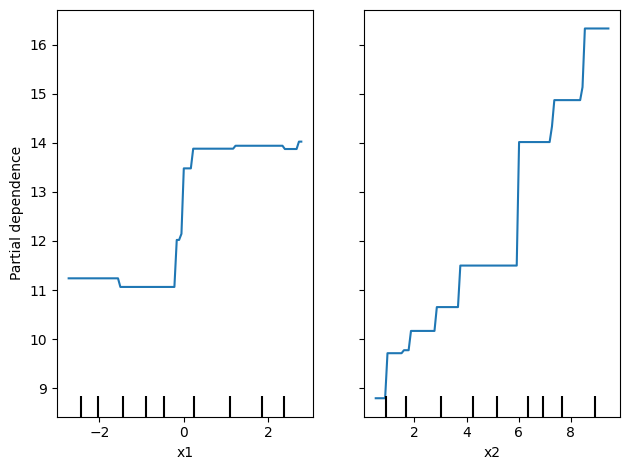

<Figure size 600x500 with 0 Axes>

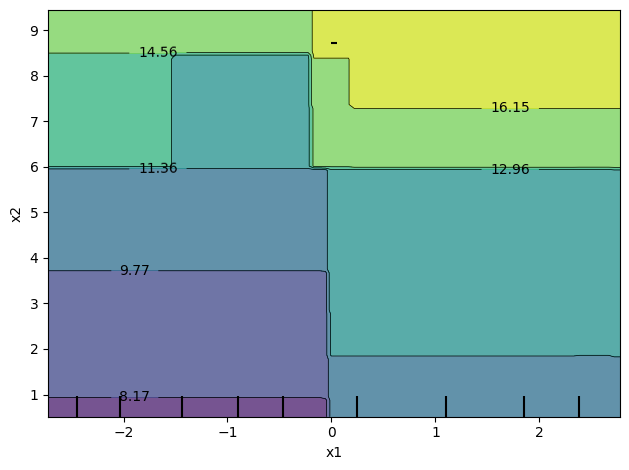

In [14]:
# -----------------------------
# 8) Partial Dependence (1D & 2D)
# -----------------------------
fig = plt.figure(figsize=(10,4))
PartialDependenceDisplay.from_estimator(best_tree, X_valid, [0,1], feature_names=feature_names) # two 1D PDPs
plt.tight_layout()
plt.show()


fig = plt.figure(figsize=(6,5))
PartialDependenceDisplay.from_estimator(best_tree, X_valid, [(0,1)], feature_names=feature_names)
plt.tight_layout()
plt.show()

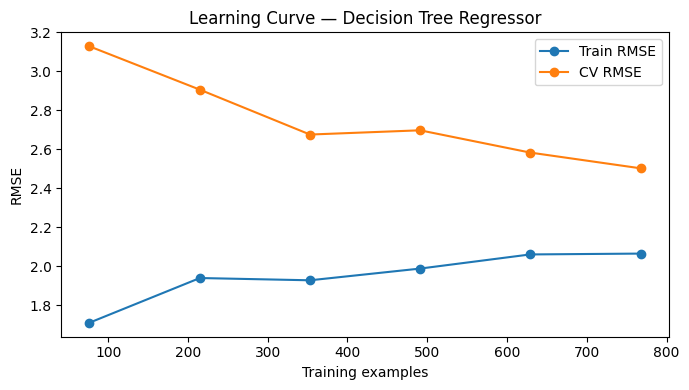

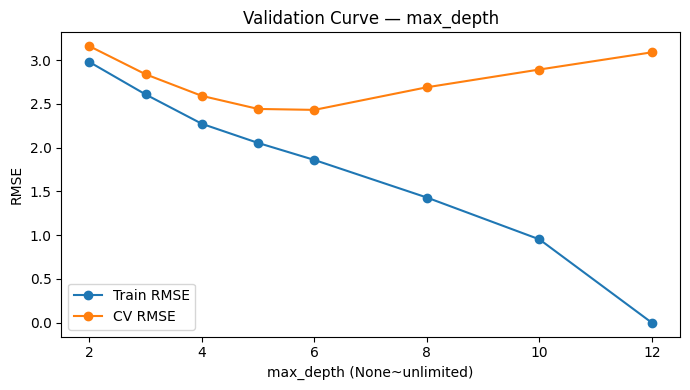

In [15]:
# -----------------------------
# 9) Learning curve and validation curve
# -----------------------------
ss = ShuffleSplit(n_splits=5, test_size=0.2, random_state=RANDOM_STATE)
train_sizes, train_scores, valid_scores = learning_curve(
best_tree, X_train_val, y_train_val, cv=ss, scoring="neg_root_mean_squared_error",
train_sizes=np.linspace(0.1, 1.0, 6), n_jobs=-1
)


plt.figure(figsize=(7,4))
plt.plot(train_sizes, -train_scores.mean(axis=1), marker='o', label='Train RMSE')
plt.plot(train_sizes, -valid_scores.mean(axis=1), marker='o', label='CV RMSE')
plt.xlabel("Training examples")
plt.ylabel("RMSE")
plt.title("Learning Curve — Decision Tree Regressor")
plt.legend(); plt.tight_layout(); plt.show()


# Validation curve for max_depth
param_range = [2, 3, 4, 5, 6, 8, 10, None]
train_scores, valid_scores = validation_curve(
Pipeline([("pre", preprocess), ("tree", DecisionTreeRegressor(random_state=RANDOM_STATE))]),
X_train_val, y_train_val,
param_name="tree__max_depth",
param_range=param_range,
cv=5,
scoring="neg_root_mean_squared_error",
n_jobs=-1
)


plt.figure(figsize=(7,4))
# Convert None to a number for plotting
x_vals = [d if d is not None else 12 for d in param_range]
plt.plot(x_vals, -train_scores.mean(axis=1), marker='o', label='Train RMSE')
plt.plot(x_vals, -valid_scores.mean(axis=1), marker='o', label='CV RMSE')
plt.xlabel("max_depth (None~unlimited)")
plt.ylabel("RMSE")
plt.title("Validation Curve — max_depth")
plt.legend(); plt.tight_layout(); plt.show()

In [16]:
# -----------------------------
# 10) Sample weights example
# -----------------------------
weights = np.ones_like(y_train)
# upweight high-target samples to emphasize them in training
weights[y_train > np.percentile(y_train, 75)] = 2.0
weighted_tree = Pipeline([
("pre", preprocess),
("tree", DecisionTreeRegressor(random_state=RANDOM_STATE, max_depth=5))
])
weighted_tree.fit(X_train, y_train, tree__sample_weight=weights)
regression_report(y_valid, weighted_tree.predict(X_valid), label="Weighted Tree")

[Weighted Tree] MAE=2.0397 RMSE=2.5640 R2=0.6198 MAPE=0.211


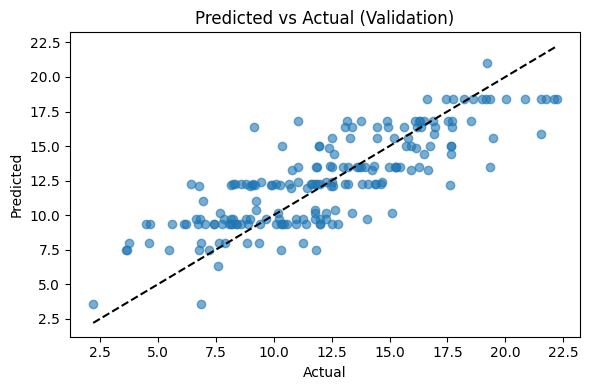

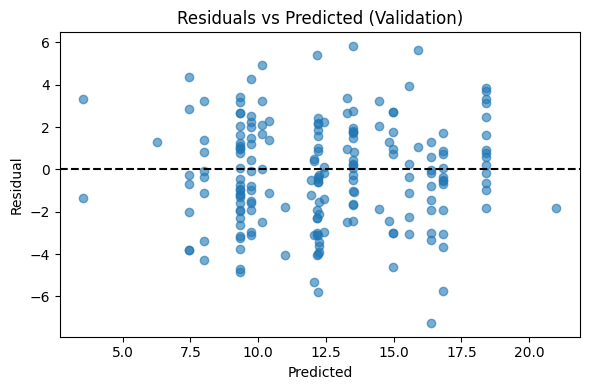

In [17]:
# -----------------------------
# 11) Residual diagnostics & scatter plots
# -----------------------------
final_model = pruned_tree # choose one (best_tree / pruned_tree)
y_pred_val = final_model.predict(X_valid)


plt.figure(figsize=(6,4))
plt.scatter(y_valid, y_pred_val, alpha=0.6)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual (Validation)")
lim_min = min(y_valid.min(), y_pred_val.min()); lim_max = max(y_valid.max(), y_pred_val.max())
plt.plot([lim_min, lim_max],[lim_min, lim_max],'k--'); plt.tight_layout(); plt.show()


resid = y_valid - y_pred_val
plt.figure(figsize=(6,4))
plt.scatter(y_pred_val, resid, alpha=0.6)
plt.axhline(0, color='k', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.title("Residuals vs Predicted (Validation)")
plt.tight_layout(); plt.show()

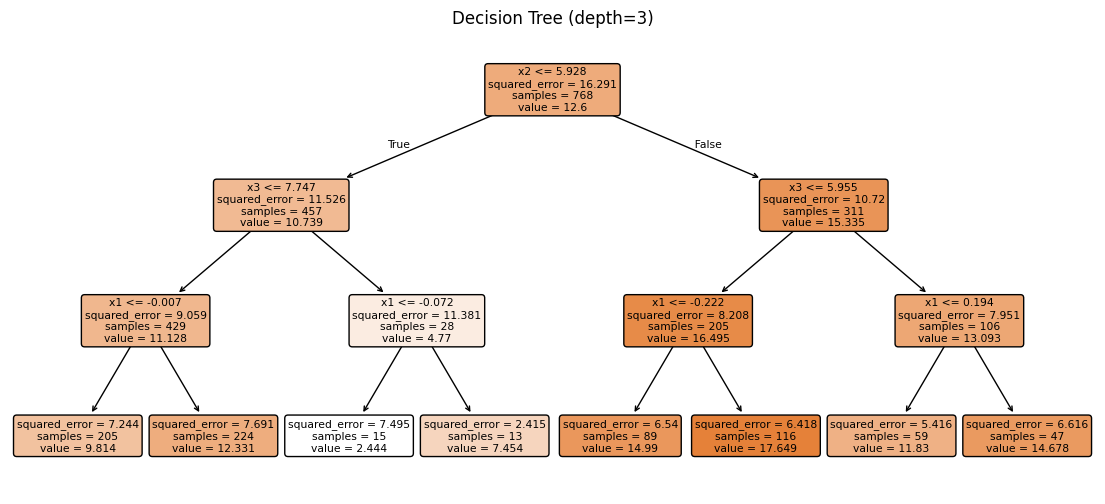

In [18]:
# -----------------------------
# 12) Visualize the tree (small depth recommended)
# -----------------------------
small_tree = Pipeline([
("pre", preprocess),
("tree", DecisionTreeRegressor(max_depth=3, random_state=RANDOM_STATE))
]).fit(X_train, y_train)


# Extract the inner tree fitted on numeric array for plotting
X_all_pre = small_tree.named_steps["pre"].fit_transform(X_train, y_train)
inner_small = DecisionTreeRegressor(max_depth=3, random_state=RANDOM_STATE)
inner_small.fit(X_all_pre, y_train)


plt.figure(figsize=(14,6))
plot_tree(inner_small, feature_names=feature_names, filled=True, rounded=True)
plt.title("Decision Tree (depth=3)")
plt.show()

In [19]:
# -----------------------------
# 13) Final evaluation on TEST set and persistence
# -----------------------------
final_model.fit(X_train_val, y_train_val) # refit on train+valid


print("\n=== Final Test Evaluation ===")
test_pred = final_model.predict(X_test)
regression_report(y_test, test_pred, label="Final Model (Test)")


# Save model
joblib.dump(final_model, "decision_tree_regression_pipeline.joblib")
print("Saved: decision_tree_regression_pipeline.joblib")


# Load & sanity check
loaded = joblib.load("decision_tree_regression_pipeline.joblib")
regression_report(y_test, loaded.predict(X_test), label="Loaded Model (Test)")


print("\nDone.")


=== Final Test Evaluation ===
[Final Model (Test)] MAE=1.9751 RMSE=2.4803 R2=0.7070 MAPE=0.257
Saved: decision_tree_regression_pipeline.joblib
[Loaded Model (Test)] MAE=1.9751 RMSE=2.4803 R2=0.7070 MAPE=0.257

Done.
